###What this is

This notebook took inspiration from the paper "Data Expansion using Back Translation and Paraphrasing for Hate Speech Detection" by Djamila Romaissa Beddiar, Md Saroar Jahan, Mourad Oussalah (https://arxiv.org/abs/2106.04681)

Here I'll use data augmentation on the dataset during training to create paraphrases of the tweets, thereby increasing the data size while keeping the same semantics.

The paper compared augmenting the entire dataset vs only augmenting the minority class, and found that augmenting the whole dataset gives better results. So I'll augment the whole dataset and use weighted sampling like what I did on the basic BERT model.

Disclaimer: because of time and resource constraints I can only do augmentation for 200 samples. It's obviously not enough to significantly affect model performance but I hope it's enough for a concept demo.

An augmented dataset is already prepped. See `data_back_translation` notebook for the data augmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/hate_speech

/content/drive/MyDrive/hate_speech


In [ ]:
!pip install transformers
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
!pip install numpy requests nlpaug

In [ ]:
import csv
import torch
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler

import os

Fixed random seed for reproducibility

In [ ]:
import random

my_seed = 79
random.seed(my_seed)
np.random.seed(my_seed)
torch.manual_seed(my_seed)
torch.cuda.manual_seed_all(my_seed)

In [ ]:
df = pd.read_csv('train_augmented_data.csv')
df.set_index('id', inplace = True)
print(df.Label.value_counts())

none      8881
sexism    2568
racism    1580
Name: Label, dtype: int64


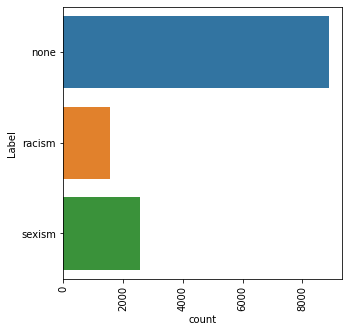

In [ ]:
import seaborn as sns
plt.figure(figsize=(5,5))
plt.xticks(rotation=90)
sns.countplot(y="Label", data=df)

Ratio of classes are roughly the same as pre augmented data, as expected

In [ ]:
possible_labels = df.Label.unique()
label_dict={}
for index,possible_label in enumerate(possible_labels):
  label_dict[possible_label] = index

In [ ]:
df['label_id'] = df.Label.replace(label_dict)
df.head()

,Tweets,Label,label_id
id,,,
0,The jokes and puns are flying free in this cam...,none,0
1,#MKR Lets see who the producers think are goin...,none,0
2,Praying Jac and Shaz do well! They're my faves...,none,0
3,RT @realityraver: Pete Evans the Paleo Capital...,none,0
4,If Kat and Andre stay tonight I will stop watc...,none,0


Fixed random seed here like others above

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label_id.values,
    test_size = 0.15,
    random_state = 79,
    
)

In [ ]:
df ['data_type'] = "notset"
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
)

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type == 'train'].Tweets.values,
    add_special_tokens = True,
    return_attention_mask = True,
    padding = 'longest',
    truncation = True,
    return_tensors = 'pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type == 'val'].Tweets.values,
    add_special_tokens = True,
    return_attention_mask = True,
    padding = 'longest',
    truncation = True,
    return_tensors = 'pt'
)



input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].label_id.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].label_id.values)

In [ ]:
df.head()
df.data_type.value_counts()

train    11074
val       1955
Name: data_type, dtype: int64

In [ ]:
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train,labels_train)
dataset_val = TensorDataset(input_ids_val,
                              attention_masks_val,labels_val)

In [ ]:


model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(label_dict),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
batch_size = 8

# imbalanced dataset, so we need a weighted sampler

class_sample_count_train = np.array([len(np.where(labels_train == t)[0]) for t in np.unique(labels_train)])
weight_train = 1. / class_sample_count_train
samples_weight_train = np.array([weight_train[t] for t in labels_train])


samples_weight_train = torch.from_numpy(samples_weight_train).double()
sampler_train = WeightedRandomSampler(samples_weight_train, len(samples_weight_train))


dataloader_train = DataLoader(
    dataset_train,
    sampler = sampler_train,
    batch_size = batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler = RandomSampler(dataset_val),
    batch_size = batch_size
)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

epochs = 3

schduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = len(dataloader_train)*epochs
)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v:k for k,v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
      y_preds = preds_flat[labels_flat == label]
      y_true = labels_flat[labels_flat == label]
      print(f'Class:{label_dict_inverse[label]}')
      print(f'Accuracy:{len(y_preds[y_preds == label])}/{len(y_true)}\n')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
def evaluate(model, dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train,
                        desc = 'Epoch {:1d}'.format(epoch),
                        leave = False,
                        disable = False)
    for batch in progress_bar:

      model.zero_grad()

      batch = tuple(b.to(device) for b in batch)

      inputs = {
          'input_ids': batch[0],
          'attention_mask': batch[1],
          'labels': batch[2]
      }
      outputs = model(**inputs)

      loss = outputs[0]
      loss_train_total += loss.item()
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
  

      optimizer.step()
      schduler.step()

      progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
    torch.save(model.state_dict(),f'BERT_augmented_epoch{epoch}.model')

    tqdm.write(f'Epoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss:{loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(model, dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss:{val_loss}')
    tqdm.write(f'F1 score (weighted):{val_f1}')


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1385 [00:00<?, ?it/s]

Epoch 1
Training loss:0.42103155161445754
Validation loss:0.7094831144665272
F1 score (weighted):0.7862048653829836


Epoch 2:   0%|          | 0/1385 [00:00<?, ?it/s]

Epoch 2
Training loss:0.269532054121058
Validation loss:0.7164047584393803
F1 score (weighted):0.8242796224701208


Epoch 3:   0%|          | 0/1385 [00:00<?, ?it/s]

Epoch 3
Training loss:0.21302434958026673
Validation loss:0.6355624234807506
F1 score (weighted):0.8527504763662067


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
model.load_state_dict(
    torch.load('BERT_augmented_epoch3.model',
               map_location = torch.device('cpu'))
)

<All keys matched successfully>

In [ ]:
_,predictions, true_vals = evaluate(model, dataloader_val)
print(predictions, true_vals)
accuracy_per_class(predictions, true_vals)

[[ 4.7048645  -2.6683109  -1.9911166 ]
 [ 0.1393139   4.991794   -3.6323898 ]
 [-0.72633684 -3.9100718   3.592475  ]
 ...
 [ 0.21430463 -4.2894397   3.1460152 ]
 [ 4.401187   -2.6655567  -1.7601291 ]
 [-1.2372963  -4.592123    4.414154  ]] [0 1 2 ... 2 0 2]
Class:none
Accuracy:1119/1341

Class:racism
Accuracy:205/236

Class:sexism
Accuracy:334/378

